<a href="https://colab.research.google.com/github/BonanYang/GNN/blob/main/GNN_Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install node2vec

In [ ]:
import networkx as nx
import numpy as np
import random
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn as nn
import torch.optim as optim
from gensim.models import Word2Vec

In [ ]:
G = nx.les_miserables_graph()
G.number_of_edges()
list(G.nodes())[:5]


['Napoleon', 'Myriel', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo']

#From Scratch

In [ ]:
def get_random_walk(node,length=5,p=1,q=1):
  d=[node]
  for _ in range(length):
    cur = d[-1]
    neighbors = list(G.neighbors(cur))
    if len(neighbors) == 0:
        break

    if len(d) == 1:
      next_node = random.choice(neighbors)

    else:
      prev = d[-2]
      weights = []
      for i in neighbors:
        if i == prev:
          weights.append(1/p)
        elif G.has_edge(i,prev):
          weights.append(1)
        else:
          weights.append(1/q)
      weights = np.array(weights)
      weights = weights/weights.sum()
      next_node = np.random.choice(neighbors,p=weights)

    d.append(next_node)
  return d
get_random_walk('Myriel',p=1,q=1,length=5)

gamma = 600
walk_len= 5
data = []
n = list(G.nodes())
for i in tqdm(n):
  for _ in range(gamma):
    data.append(get_random_walk(i,length=10,p=1,q=3))


100%|██████████| 77/77 [00:16<00:00,  4.76it/s]


In [ ]:
class W2v:
  def __init__(self,lr=0.001,embedding_dim=100,window_size=2):
    self.window_size = window_size
    self.embedding_dim = embedding_dim
    self.lr =lr
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def build_vocab(self,data):
    vocab = set()
    for i in data:
      vocab.update(i)
    vocab = list(vocab)
    self.word2idx = {j:i for i,j in enumerate(vocab)}
    self.idx2word = {i:j for i,j in enumerate(vocab)}
    self. vocab_size = len(vocab)
    return vocab

  def training_data(self,data):
    training_d = []
    for d in data:
      for i in range(self.window_size,len(d)-self.window_size):
        center_word = d[i]
        for j in range(i-self.window_size,i+self.window_size+1):
          if j!= i:
            context_word = d[j]
            training_d.append((d[i],d[j]))
    return training_d

  def build_model(self):
    class skipGram(nn.Module):
      def __init__(self,vocab_size, embedding_dim):
        super().__init__()
        self.center_embedding = nn.Embedding(vocab_size,embedding_dim)
        self.context_embedding = nn.Embedding(vocab_size,embedding_dim)

      def forward(self,center_words,context_words):
        center_embeds = self.center_embedding(center_words)
        context_embeds = self.context_embedding(context_words)
        score = torch.sum(center_embeds * context_embeds, dim=1)
        return score

    self.model = skipGram(self.vocab_size,self.embedding_dim).to(self.device)
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    self.loss_function = nn.BCEWithLogitsLoss()

  def train(self,data,epochs=5,batch_size=512,negative_samples=5):
    self.build_vocab(data)
    t_data = self.training_data(data)
    self.build_model()
    self.model.train()
    for e in range(epochs):
      total_loss = 0
      np.random.shuffle(t_data)
      for j in range(0,len(t_data),batch_size):
        batch = t_data[j:j+batch_size]
        center_words = []
        context_words = []
        labels = []
        for cent,ctx in batch:
          cent_idx = self.word2idx[cent]
          ctx_idx = self.word2idx[ctx]
          center_words.append(cent_idx)
          context_words.append(ctx_idx)
          labels.append(1.0)

          for _ in range(negative_samples):
              neg_context = np.random.randint(0, self.vocab_size)
              center_words.append(cent_idx)
              context_words.append(neg_context)
              labels.append(0.0)

        center_words = torch.tensor(center_words, dtype=torch.long).to(self.device)
        context_words = torch.tensor(context_words, dtype=torch.long).to(self.device)
        labels = torch.tensor(labels, dtype=torch.float).to(self.device)
        self.optimizer.zero_grad()
        scores = self.model(center_words, context_words)
        loss = self.loss_function(scores, labels)
        loss.backward()
        self.optimizer.step()
        total_loss += loss.item()


      avg_loss = total_loss / (len(t_data) // batch_size)
      print(f'Epoch {e+1}/{epochs}, Loss: {avg_loss:.4f}')

  def get_word_emb(self,word):
    idx = self.word2idx[word]
    idx_tensor = torch.tensor([idx]).to(self.device)
    return self.model.center_embedding(idx_tensor).detach().cpu().numpy()[0]



In [ ]:
model = W2v()
model.train(data)

Epoch 1/5, Loss: 0.7731
Epoch 2/5, Loss: 0.2606
Epoch 3/5, Loss: 0.2508
Epoch 4/5, Loss: 0.2481
Epoch 5/5, Loss: 0.2470


# Using Node2Vec

In [ ]:
node2vec = Node2Vec(G,
                    dimensions=32,
                    p=1,
                    q=0.5,
                    walk_length=10,
                    num_walks=600,
                    workers=4
                   )

# p=1, q=0.5, n_clusters=6。DFS
# p=1, q=2, n_clusters=3。BFS

model = node2vec.fit(window=3,
                     min_count=1,
                     batch_words=4
                    )
X = model.wv.vectors

Computing transition probabilities:   0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
cluster_labels = KMeans(n_clusters=3).fit(X).labels_
print(cluster_labels)

[2 2 0 1 2 2 1 1 2 2 1 1 0 2 0 2 1 2 1 1 1 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1
 2 2 1 1 1 1 2 1 1 1 2 1 2 2 2 0 2 2 2 2 2 1 2 2 2 0 0 0 0 0 0 1 2 2 2 2 2
 2 2 2]


In [ ]:
colors = []
nodes = list(G.nodes)
for node in nodes:
    idx = model.wv.key_to_index[str(node)]
    colors.append(cluster_labels[idx])


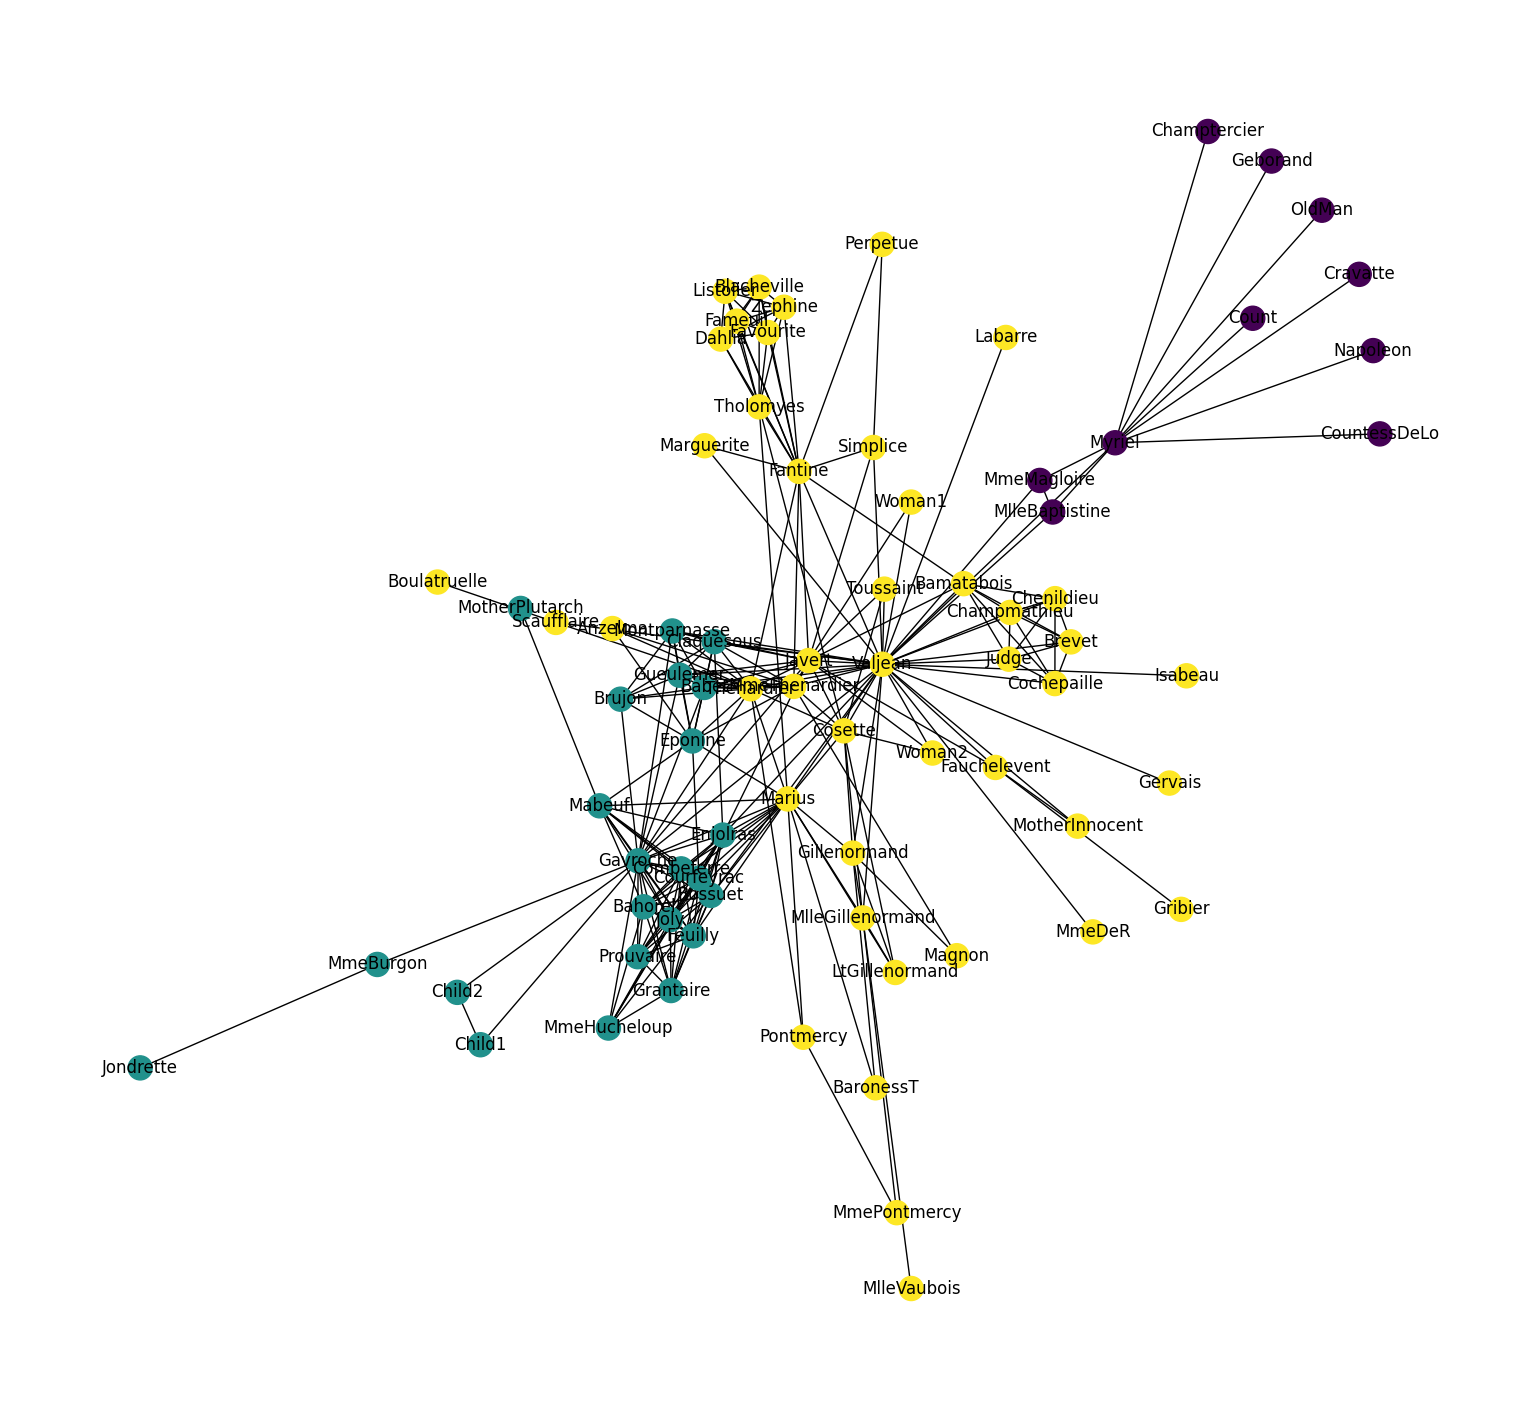

In [ ]:
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=10)
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.show()